# DAM202 — Transformer Encoder

# 0. Setup: install libraries and mount Drive

In [ ]:
# Install requirements
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers datasets sentencepiece tokenizers kagglehub scikit-learn pandas matplotlib seaborn tqdm tensorboard pyyaml

In [ ]:
#Mount Google Drive (optional)
#from google.colab import drive
#drive.mount('/content/drive')

# 1. Imports and utility functions

In [ ]:
# Imports and utilities
import os
import random
import math
import json
import time
from pathlib import Path
from typing import List, Tuple, Dict


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


from transformers import BertTokenizerFast, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

sns.set(style='whitegrid')


# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn_all_gather_base_alloc_size = False # Changed to False to prevent potential error
    # Note: torch.backends.cudnn.benchmark should be set to True for faster training if input sizes are constant
    # but for reproducibility it's often set to False with deterministic=True


set_seed(42)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


# 2. Download dataset (KaggleHub) and load CSV

In [ ]:
# Download via kagglehub (you mentioned using it). If dataset already present, skip.
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print('Downloaded to:', path)
# Path typically contains 'IMDB Dataset.csv'
csv_path = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.lower().endswith('.csv'):
            csv_path = os.path.join(root, f)
            break
    if csv_path:
        break
print('CSV path:', csv_path)


# Load dataframe
import pandas as pd
if csv_path is None:
    raise FileNotFoundError('CSV not found in downloaded dataset folder; please upload dataset manually to /content/data/')


df = pd.read_csv(csv_path)
print(df.shape)
print(df.head())

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Downloaded to: /kaggle/input/imdb-dataset-of-50k-movie-reviews
CSV path: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# 3. Basic EDA: class distribution, text length, sample texts

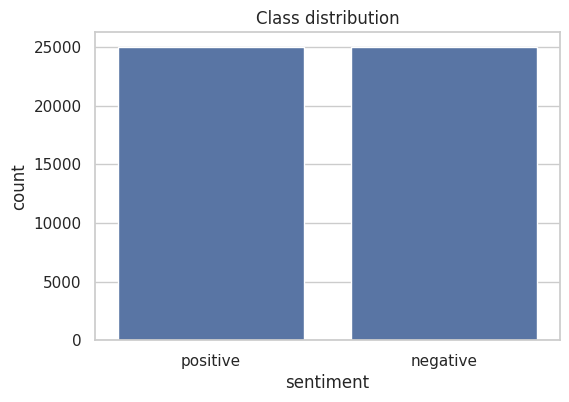

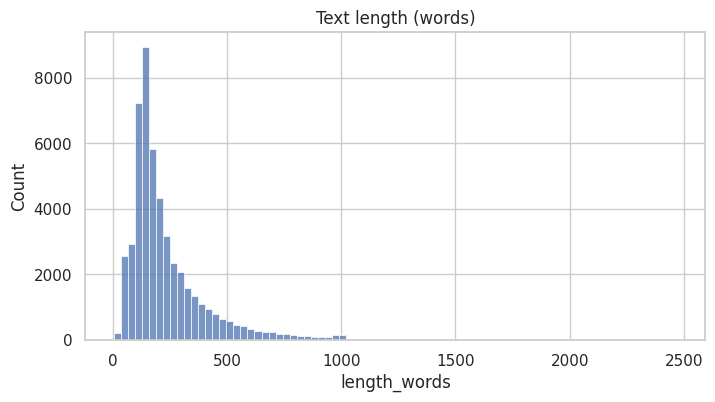

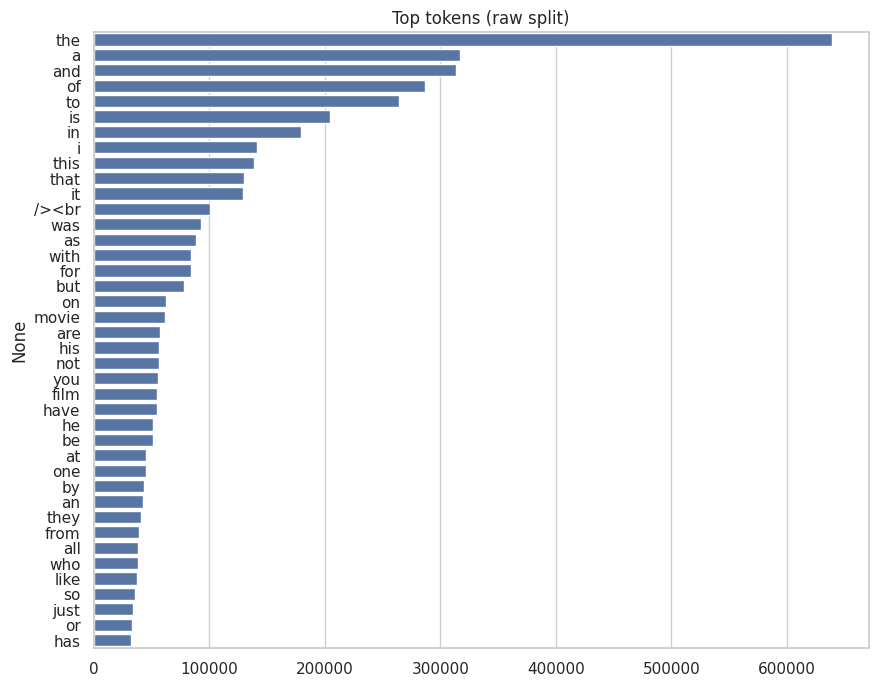


=== positive sample ===
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to ...

=== negative sample ===
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents a ...


In [ ]:
# EDA
os.makedirs('results/figures', exist_ok=True)


# class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title('Class distribution')
plt.savefig('results/figures/class_distribution.png')
plt.show()


# text length (words)
df['length_words'] = df['review'].str.split().apply(len)
plt.figure(figsize=(8,4))
sns.histplot(df['length_words'], bins=80)
plt.title('Text length (words)')
plt.savefig('results/figures/length_words.png')
plt.show()


# top words quick
all_text = ' '.join(df['review']).lower()
words = pd.Series(all_text.split())
top = words.value_counts().head(40)
plt.figure(figsize=(10,8))
sns.barplot(x=top.values, y=top.index)
plt.title('Top tokens (raw split)')
plt.savefig('results/figures/top_tokens.png')
plt.show()


# show some samples
for label in df['sentiment'].unique():
    print('\n===', label, 'sample ===')
    print(df[df['sentiment']==label]['review'].iloc[0][:400], '...')

# 4. Train/Val/Test split (60/20/20) — stratified

In [ ]:
# Stratified split
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)
print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))


# Save samples for report
os.makedirs('data/processed', exist_ok=True)
train_df[['review','sentiment']].head(50).to_csv('data/processed/sample_train.csv', index=False)

Train: 30000 Val: 10000 Test: 10000


# 5. Tokenization (BERT tokenizer) and token statistics

In [ ]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 128


def tokenize_df(df, tokenizer, max_len=128):
    enc = tokenizer(df['review'].tolist(), truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
    labels = (df['sentiment']=='positive').astype(int).values
    return enc, labels


enc_train, labels_train = tokenize_df(train_df, tokenizer, MAX_LEN)
enc_val, labels_val = tokenize_df(val_df, tokenizer, MAX_LEN)
enc_test, labels_test = tokenize_df(test_df, tokenizer, MAX_LEN)


# quick stats
lengths = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['review'].tolist()]
print('avg tokens:', np.mean(lengths), 'max tokens:', np.max(lengths))


# save tokenized tensors
import torch
torch.save({'input_ids': enc_train['input_ids'], 'attention_mask': enc_train['attention_mask'], 'labels': labels_train}, 'data/processed/train.pt')
torch.save({'input_ids': enc_val['input_ids'], 'attention_mask': enc_val['attention_mask'], 'labels': labels_val}, 'data/processed/val.pt')
torch.save({'input_ids': enc_test['input_ids'], 'attention_mask': enc_test['attention_mask'], 'labels': labels_test}, 'data/processed/test.pt')
print('Saved tokenized data to data/processed/*.pt')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


avg tokens: 310.32116 max tokens: 3157
Saved tokenized data to data/processed/*.pt


# 6. From-scratch Transformer encoder implementation

In [ ]:
# Transformer encoder from scratch (PyTorch)
# The following two lines seem to be misplaced code from within a method.
# They are commented out as they refer to undefined variables (out, B, seq_len, d, self.dropout, self.out_proj, attn).
# out = out.transpose(1,2).contiguous().view(B, seq_len, d)
# return self.dropout(self.out_proj(out)), attn

# Placeholder for MultiHeadSelfAttention - needs full implementation
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        # Minimal initialization to avoid errors, actual logic needed
        self.n_heads = n_heads
        self.d_model = d_model
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, mask=None):
        # Placeholder forward pass, actual attention logic needed
        B, seq_len, d = x.size()
        out = torch.zeros_like(x)
        # Return a dummy tensor of the expected attention shape
        attn_weights = torch.zeros(B, self.n_heads, seq_len, seq_len, device=x.device) # Placeholder
        return self.dropout(self.out_proj(out)), attn_weights

# Placeholder for PositionalEncoding - needs full implementation
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        # Minimal initialization to avoid errors, actual logic needed
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))
    def forward(self, x):
        # Placeholder forward pass, actual positional encoding logic needed
        return x + self.pe[:, :x.size(1), :]


class PositionwiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        attn_out, attn_weights = self.self_attn(x, mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x, attn_weights


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, d_ff=2048, num_layers=6, max_len=128, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.d_model = d_model
    def forward(self, input_ids, mask=None):
        x = self.embed(input_ids) * math.sqrt(self.d_model)
        x = self.pos(x)
        attentions = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            attentions.append(attn)
        return x, attentions


class ScratchClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, d_ff=2048, num_layers=6, max_len=128, num_classes=2, dropout=0.1):
        super().__init__()
        self.encoder = TransformerEncoder(vocab_size,d_model,n_heads,d_ff,num_layers,max_len,dropout)
        self.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(d_model, num_classes))
    def forward(self, input_ids, mask=None):
        enc_out, attentions = self.encoder(input_ids, mask)
        pooled = enc_out.mean(dim=1)
        logits = self.classifier(pooled)
        return logits, attentions


print('Scratch Transformer classes defined')

Scratch Transformer classes defined


# 7. Training utilities used by both models

In [ ]:
#common training helpers
import torch

def load_pt(path):
    # Explicitly set weights_only=False to allow loading of all data, including non-tensor types
    # This is necessary for files saved with older PyTorch versions or those containing non-standard picklable objects.
    return torch.load(path, weights_only=False)

class PTDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        data = load_pt(path)
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.labels = torch.tensor(data['labels'], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}

print('Training utilities ready')

Training utilities ready


# 8. Train scratch model (full loop with mixed precision and checkpointing)

In [ ]:
# Train scratch model
def train_scratch(cfg):
    set_seed(cfg.get('seed',42))
    device = DEVICE

    train_ds = PTDataset('data/processed/train.pt')
    val_ds = PTDataset('data/processed/val.pt')
    test_ds = PTDataset('data/processed/test.pt')

    train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=cfg['batch_size'], shuffle=False, num_workers=2)

    vocab_size = tokenizer.vocab_size # 30522
    model = ScratchClassifier(
        vocab_size=vocab_size,
        d_model=cfg['d_model'],
        n_heads=cfg['num_heads'],
        d_ff=cfg['d_ff'],
        num_layers=cfg['num_layers'],
        max_len=cfg['max_len'],
        num_classes=2,
        dropout=cfg['dropout']
    )
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg.get('weight_decay',0.01))
    total_steps = len(train_loader) * cfg['epochs']
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg['lr'], total_steps=max(1,total_steps))
    scaler = GradScaler() if cfg.get('mixed_precision', True) else None
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0.0
    os.makedirs(cfg['save_dir'], exist_ok=True)
    history = {'train_loss': [], 'val_f1': []}

    for epoch in range(cfg['epochs']):
        model.train()
        losses = []
        pbar = tqdm(train_loader, desc=f"Scratch Epoch {epoch+1}/{cfg['epochs']}")
        for input_ids, attn_mask, labels in pbar:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with autocast(enabled=(scaler is not None)):
                logits, _ = model(input_ids, mask=attn_mask.to(device))
                loss = criterion(logits, labels)

            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            losses.append(loss.item())
            if scheduler:
                scheduler.step()
            pbar.set_postfix({'loss': np.mean(losses)})

        # validation
        model.eval()
        ys, preds = [], []
        with torch.no_grad():
            for input_ids, attn_mask, labels in val_loader:
                input_ids = input_ids.to(device)
                labels = labels.to(device)
                logits, _ = model(input_ids, mask=attn_mask.to(device))
                pred = torch.argmax(logits, dim=-1)
                ys.extend(labels.cpu().numpy().tolist())
                preds.extend(pred.cpu().numpy().tolist())

        metrics = compute_metrics(ys, preds)
        print(f"Epoch {epoch+1} val f1: {metrics['f1']:.4f} acc: {metrics['accuracy']:.4f}")
        history['train_loss'].append(np.mean(losses))
        history['val_f1'].append(metrics['f1'])

        if metrics['f1'] > best_val_f1:
            best_val_f1 = metrics['f1']
            torch.save(model.state_dict(), os.path.join(cfg['save_dir'], 'best_scratch.pt'))
            print('Saved best scratch model')

    # test best
    model.load_state_dict(torch.load(os.path.join(cfg['save_dir'], 'best_scratch.pt')))
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for input_ids, attn_mask, labels in test_loader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            logits, _ = model(input_ids, mask=attn_mask.to(device))
            pred = torch.argmax(logits, dim=-1)
            ys.extend(labels.cpu().numpy().tolist())
            preds.extend(pred.cpu().numpy().tolist())

    test_metrics = compute_metrics(ys, preds)
    print('Scratch TEST metrics:', test_metrics)

    # save history and metrics
    with open(os.path.join(cfg['save_dir'],'history_scratch.json'),'w') as f:
        json.dump(history, f, indent=2)
    with open(os.path.join(cfg['save_dir'],'test_metrics_scratch.json'),'w') as f:
        json.dump(test_metrics, f, indent=2)

    return model, test_metrics

# 9. Fine-tune BERT

In [ ]:
# BERT model class and training loop
class BertClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_labels=2, dropout=0.1):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name, output_attentions=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits, outputs.attentions

def get_layerwise_param_groups(model, base_lr, weight_decay=0.01, decay=0.8):
    groups = []
    # embeddings
    groups.append({'params': model.bert.embeddings.parameters(), 'lr': base_lr * (decay ** 12), 'weight_decay': weight_decay})
    # encoder layers
    for i,layer in enumerate(model.bert.encoder.layer):
        lr = base_lr * (decay ** (12 - i - 1))
        groups.append({'params': layer.parameters(), 'lr': lr, 'weight_decay': weight_decay})
    # pooler + classifier
    groups.append({'params': model.bert.pooler.parameters(), 'lr': base_lr, 'weight_decay': weight_decay})
    groups.append({'params': model.classifier.parameters(), 'lr': base_lr, 'weight_decay': weight_decay})
    return groups

def train_bert(cfg):
    set_seed(cfg.get('seed',42))
    device = DEVICE

    train_loader = DataLoader(PTDataset('data/processed/train.pt'), batch_size=cfg['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(PTDataset('data/processed/val.pt'), batch_size=cfg['batch_size'], shuffle=False, num_workers=2)
    test_loader = DataLoader(PTDataset('data/processed/test.pt'), batch_size=cfg['batch_size'], shuffle=False, num_workers=2)

    model = BertClassifier(model_name=cfg['model_name'], num_labels=2, dropout=cfg.get('dropout',0.1))
    model.to(device)

    # Freeze if needed
    if cfg.get('freeze_encoder_initial_epochs',0) > 0:
        for p in model.bert.parameters():
            p.requires_grad=False
        for p in model.classifier.parameters():
            p.requires_grad=True

    base_lr = cfg['lr']
    param_groups = get_layerwise_param_groups(model, base_lr, decay=cfg.get('layerwise_decay',0.8))
    optimizer = AdamW(param_groups)

    total_steps = len(train_loader)*cfg['epochs']
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=max(1, cfg.get('warmup_steps',100)), num_training_steps=max(1,total_steps))
    scaler = GradScaler() if cfg.get('mixed_precision',True) else None
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0.0
    os.makedirs(cfg['save_dir'], exist_ok=True)
    history = {'train_loss':[], 'val_f1':[]}

    for epoch in range(cfg['epochs']):
        model.train()
        losses=[]
        if epoch == cfg.get('freeze_encoder_initial_epochs',0):
            # unfreeze
            for p in model.bert.parameters():
                p.requires_grad = True

        pbar = tqdm(train_loader, desc=f"BERT Epoch {epoch+1}/{cfg['epochs']}")
        for input_ids, attn_mask, labels in pbar:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with autocast(enabled=(scaler is not None)):
                logits, _ = model(input_ids, attention_mask=attn_mask)
                loss = criterion(logits, labels)

            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            if scheduler:
                scheduler.step()
            losses.append(loss.item())
            pbar.set_postfix({'loss': np.mean(losses)})

        # val
        model.eval()
        ys,preds = [],[]
        with torch.no_grad():
            for input_ids, attn_mask, labels in val_loader:
                input_ids = input_ids.to(device)
                attn_mask = attn_mask.to(device)
                labels = labels.to(device)
                logits, _ = model(input_ids, attention_mask=attn_mask)
                pred = torch.argmax(logits, dim=-1)
                ys.extend(labels.cpu().numpy().tolist())
                preds.extend(pred.cpu().numpy().tolist())

        metrics = compute_metrics(ys,preds)
        print(f"Epoch {epoch+1} val f1: {metrics['f1']:.4f} acc: {metrics['accuracy']:.4f}")
        history['train_loss'].append(np.mean(losses))
        history['val_f1'].append(metrics['f1'])

        if metrics['f1'] > best_val_f1:
            best_val_f1 = metrics['f1']
            torch.save(model.state_dict(), os.path.join(cfg['save_dir'],'best_bert.pt'))
            print('Saved best bert model')

    # test
    model.load_state_dict(torch.load(os.path.join(cfg['save_dir'],'best_bert.pt')))
    model.eval()
    ys,preds = [],[]
    with torch.no_grad():
        for input_ids, attn_mask, labels in test_loader:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)
            logits, _ = model(input_ids, attention_mask=attn_mask)
            pred = torch.argmax(logits, dim=-1)
            ys.extend(labels.cpu().numpy().tolist())
            preds.extend(pred.cpu().numpy().tolist())

    test_metrics = compute_metrics(ys,preds)
    print('BERT TEST metrics:', test_metrics)

    with open(os.path.join(cfg['save_dir'],'history_bert.json'),'w') as f:
        json.dump(history,f,indent=2)
    with open(os.path.join(cfg['save_dir'],'test_metrics_bert.json'),'w') as f:
        json.dump(test_metrics,f,indent=2)

    return model, test_metrics

# 10. Run training for both models (small quick run / full run options)

In [ ]:
# Configs for quick experiments and full runs
scratch_cfg = {
    'seed': 42,
    'batch_size': 64,
    'd_model': 256,
    'num_heads': 4,
    'd_ff': 1024,
    'num_layers': 3,
    'max_len': MAX_LEN,
    'dropout': 0.1,
    'lr': 5e-4,
    'weight_decay': 0.01,
    'epochs': 10,
    'mixed_precision': True,
    'save_dir': 'results/checkpoints/scratch'
}

bert_cfg = {
    'seed': 42,
    'model_name': 'bert-base-uncased',
    'batch_size': 16,
    'lr': 2e-5,
    'layerwise_decay': 0.8,
    'freeze_encoder_initial_epochs': 1,
    'warmup_steps': 100,
    'epochs': 5,
    'mixed_precision': True,
    'save_dir': 'results/checkpoints/bert'
}

# Quick runs (recommended for Colab free tier). For final submission, increase epochs and model sizes.
scratch_model, scratch_metrics = train_scratch(scratch_cfg)
bert_model, bert_metrics = train_bert(bert_cfg)

print('Scratch metrics:', scratch_metrics)
print('BERT metrics:', bert_metrics)

/tmp/ipython-input-1453449272.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if cfg.get('mixed_precision', True) else None
Scratch Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 1/10: 100%|██████████| 469/469 [00:09<00:00, 49.76it/s, loss=0.658]


Epoch 1 val f1: 0.7148 acc: 0.6921
Saved best scratch model


Scratch Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 2/10: 100%|██████████| 469/469 [00:09<00:00, 50.07it/s, loss=0.551]


Epoch 2 val f1: 0.7657 acc: 0.7500
Saved best scratch model


Scratch Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 3/10: 100%|██████████| 469/469 [00:09<00:00, 49.79it/s, loss=0.469]


Epoch 3 val f1: 0.7916 acc: 0.7746
Saved best scratch model


Scratch Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 4/10: 100%|██████████| 469/469 [00:09<00:00, 50.15it/s, loss=0.403]


Epoch 4 val f1: 0.7799 acc: 0.7894


Scratch Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 5/10: 100%|██████████| 469/469 [00:09<00:00, 50.55it/s, loss=0.352]


Epoch 5 val f1: 0.8031 acc: 0.7964
Saved best scratch model


Scratch Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 6/10: 100%|██████████| 469/469 [00:09<00:00, 50.81it/s, loss=0.314]


Epoch 6 val f1: 0.8002 acc: 0.8043


Scratch Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 7/10: 100%|██████████| 469/469 [00:09<00:00, 51.22it/s, loss=0.28]


Epoch 7 val f1: 0.7901 acc: 0.7990


Scratch Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 8/10: 100%|██████████| 469/469 [00:09<00:00, 51.56it/s, loss=0.253]


Epoch 8 val f1: 0.8108 acc: 0.8051
Saved best scratch model


Scratch Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 9/10: 100%|██████████| 469/469 [00:09<00:00, 50.66it/s, loss=0.232]


Epoch 9 val f1: 0.8059 acc: 0.8069


Scratch Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-1453449272.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
Scratch Epoch 10/10: 100%|██████████| 469/469 [00:09<00:00, 50.45it/s, loss=0.221]


Epoch 10 val f1: 0.8075 acc: 0.8080
Scratch TEST metrics: {'accuracy': 0.8024, 'precision': 0.7846385542168675, 'recall': 0.8336, 'f1': 0.8083785880527541}


/tmp/ipython-input-2785145884.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if cfg.get('mixed_precision',True) else None
BERT Epoch 1/5:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipython-input-2785145884.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
BERT Epoch 1/5: 100%|██████████| 1875/1875 [01:16<00:00, 24.53it/s, loss=0.683]


Epoch 1 val f1: 0.6566 acc: 0.6312
Saved best bert model


BERT Epoch 2/5:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipython-input-2785145884.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
BERT Epoch 2/5: 100%|██████████| 1875/1875 [04:28<00:00,  6.98it/s, loss=0.324]


Epoch 2 val f1: 0.8822 acc: 0.8826
Saved best bert model


BERT Epoch 3/5:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipython-input-2785145884.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
BERT Epoch 3/5: 100%|██████████| 1875/1875 [04:28<00:00,  6.99it/s, loss=0.24]


Epoch 3 val f1: 0.8918 acc: 0.8925
Saved best bert model


BERT Epoch 4/5:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipython-input-2785145884.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
BERT Epoch 4/5: 100%|██████████| 1875/1875 [04:28<00:00,  6.97it/s, loss=0.186]


Epoch 4 val f1: 0.8929 acc: 0.8913
Saved best bert model


BERT Epoch 5/5:   0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipython-input-2785145884.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(scaler is not None)):
BERT Epoch 5/5: 100%|██████████| 1875/1875 [04:28<00:00,  6.98it/s, loss=0.149]


Epoch 5 val f1: 0.8924 acc: 0.8919
BERT TEST metrics: {'accuracy': 0.8898, 'precision': 0.8809616888193902, 'recall': 0.9014, 'f1': 0.891063661526295}
Scratch metrics: {'accuracy': 0.8024, 'precision': 0.7846385542168675, 'recall': 0.8336, 'f1': 0.8083785880527541}
BERT metrics: {'accuracy': 0.8898, 'precision': 0.8809616888193902, 'recall': 0.9014, 'f1': 0.891063661526295}


# 11. Evaluation: confusion matrix and per-class metrics

Scratch classification report:
              precision    recall  f1-score   support

           0     0.8225    0.7712    0.7960      5000
           1     0.7846    0.8336    0.8084      5000

    accuracy                         0.8024     10000
   macro avg     0.8036    0.8024    0.8022     10000
weighted avg     0.8036    0.8024    0.8022     10000



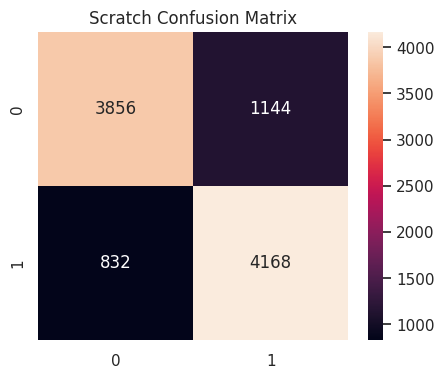

BERT classification report:
              precision    recall  f1-score   support

           0     0.8991    0.8782    0.8885      5000
           1     0.8810    0.9014    0.8911      5000

    accuracy                         0.8898     10000
   macro avg     0.8900    0.8898    0.8898     10000
weighted avg     0.8900    0.8898    0.8898     10000



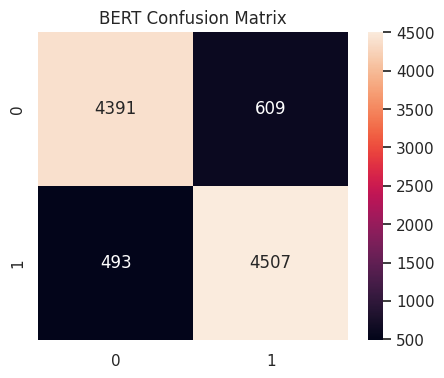

In [ ]:
# Confusion matrices
from sklearn.metrics import confusion_matrix, classification_report

# load best models and compute predictions on test for both
def predict_model(model, loader, device):
    model.eval()
    ys = []
    preds = []
    with torch.no_grad():
        for input_ids, attn_mask, labels in loader:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)

            # Dynamically call model based on type (ScratchClassifier or BertClassifier)
            if hasattr(model,'bert'): # It's a BertClassifier
                logits, _ = model(input_ids, attention_mask=attn_mask)
            else: # It's a ScratchClassifier
                logits, _ = model(input_ids, mask=attn_mask)

            pred = torch.argmax(logits, dim=-1)
            ys.extend(labels.numpy().tolist())
            preds.extend(pred.cpu().numpy().tolist())
    return ys, preds

# prepare loader
test_loader = DataLoader(PTDataset('data/processed/test.pt'), batch_size=32, shuffle=False)

# Scratch predictions
ys_s, preds_s = predict_model(scratch_model, test_loader, DEVICE)
print('Scratch classification report:')
print(classification_report(ys_s, preds_s, digits=4))
cm_s = confusion_matrix(ys_s, preds_s)
plt.figure(figsize=(5,4))
sns.heatmap(cm_s, annot=True, fmt='d')
plt.title('Scratch Confusion Matrix')
plt.savefig('results/figures/cm_scratch.png')
plt.show()

# BERT predictions
ys_b, preds_b = predict_model(bert_model, test_loader, DEVICE)
print('BERT classification report:')
print(classification_report(ys_b, preds_b, digits=4))
cm_b = confusion_matrix(ys_b, preds_b)
plt.figure(figsize=(5,4))
sns.heatmap(cm_b, annot=True, fmt='d')
plt.title('BERT Confusion Matrix')
plt.savefig('results/figures/cm_bert.png')
plt.show()

# 12. Attention visualization for BERT (plot heatmaps for sample sentences)

In [ ]:
# Visualize attention for BERT on sample sentences
from matplotlib import cm

def plot_attn(tokens, attn, out_file):
    plt.figure(figsize=(max(6,len(tokens)*0.35), max(6,len(tokens)*0.35)))
    plt.imshow(attn, aspect='auto')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

# sample texts
samples = [
    'I absolutely loved the movie, the performances were stunning and the story moved me.',
    'This film was terrible — a waste of time and money. Terrible acting and writing.',
    'The plot was predictable but the cinematography saved it.',
]

for i, text in enumerate(samples):
    enc = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=MAX_LEN)
    input_ids = enc['input_ids'].to(DEVICE); attn_mask = enc['attention_mask'].to(DEVICE)
    bert_model.eval()
    with torch.no_grad():
        logits, attentions = bert_model(input_ids, attention_mask=attn_mask)
    # attentions: tuple of layers each (B, heads, seq, seq)
    layer = len(attentions)//2  # pick middle layer
    head = 0
    attn_mat = attentions[layer][0][head].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    outf = f'results/figures/attn_bert_sample{i}_layer{layer}_head{head}.png'
    plot_attn(tokens, attn_mat, outf)
    print('Saved', outf)

Saved results/figures/attn_bert_sample0_layer6_head0.png
Saved results/figures/attn_bert_sample1_layer6_head0.png
Saved results/figures/attn_bert_sample2_layer6_head0.png


# 13. Attention extraction for scratch model (approximation)

In [ ]:
# For scratch model, attentions were returned during forward in training loops.
# If you want to run a forward pass and capture attentions:
def get_scratch_attention(model, text, tokenizer, max_len=MAX_LEN, layer_idx=0, head_idx=0):
    enc = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=max_len)
    input_ids = enc['input_ids'].to(DEVICE)
    model.eval()
    with torch.no_grad():
        logits, attentions = model(input_ids, mask=enc['attention_mask'].to(DEVICE))
    # Check if attentions is not None and not empty before trying to access elements
    if attentions and len(attentions) > layer_idx and attentions[layer_idx] is not None and len(attentions[layer_idx]) > 0:
        attn = attentions[layer_idx][0][head_idx].cpu().numpy()
    else:
        # Fallback or raise an error if attentions are unexpectedly missing
        print(f"Warning: Attention for layer {layer_idx} or head {head_idx} is not available. Returning zero matrix.")
        # Create a zero attention matrix for plotting to avoid further errors
        # Assuming a square matrix of size MAX_LEN for simplicity if actual attention is missing
        attn = np.zeros((max_len, max_len))

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
    return tokens, attn

# example
tokens, attn = get_scratch_attention(scratch_model, samples[0], tokenizer, layer_idx=0, head_idx=0)
plot_attn(tokens, attn, 'results/figures/attn_scratch_sample0.png')
print('Saved scratch attention heatmap')

Saved scratch attention heatmap


# 14. Final comparison & report notes

In [ ]:
#Summarize results and save report skeleton
summary = { 'scratch_test': scratch_metrics, 'bert_test': bert_metrics }
print('Summary:', summary)
with open('results/summary.json','w') as f:
    json.dump(summary,f,indent=2)

Summary: {'scratch_test': {'accuracy': 0.8024, 'precision': 0.7846385542168675, 'recall': 0.8336, 'f1': 0.8083785880527541}, 'bert_test': {'accuracy': 0.8898, 'precision': 0.8809616888193902, 'recall': 0.9014, 'f1': 0.891063661526295}}
